In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, ridge_regression
from sklearn.neighbors import NearestNeighbors
import lightgbm as lgb
%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv")
DATA_ZIP_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv.zip")

In [17]:
def online_clean(df):
    datetime_format = "%d/%m/%Y à %Hh%M"
    df.Online = [datetime.strptime(d, datetime_format) for d in df.Online.values]
    return df

def mileage_clean(df):
    df.Mileage = [float(m.split(' ')[0]) for m in df.Mileage.values]
    return df

def descriptions_clean(df):
    regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
    version = []
    spuissance_fiscale = []
    portes = []
    options = []
    couleur = []
    for i in range(df.shape[0]):
        match = re.search(regex_pattern, df.Description[i])
        version.append(match.group(2))
        spuissance_fiscale.append(match.group(3))
        portes.append(match.group(4))
        options.append(match.group(5))
        couleur.append(match.group(6))
    df["version"] = list(map(str.lower, version))
    df["spuissance_fiscale"] = spuissance_fiscale
    df["portes"] = portes
    df["options"] = options
    df["couleur"] = list(map(str.lower, couleur))
    del df["Description"]
    return df

def offre_duplication_clean(df):
    fix_col = list(df.columns)
    fix_col.remove("Online")
    fix_col.remove("Price")
    duplicateRowsDF = df[df.sort_values(by="Online").duplicated(fix_col, keep='last')]
    row_maintain = list(set(df.index) - set(list(duplicateRowsDF.index)))
    df = df.loc[row_maintain, :]
    return df

def price_log_transformation(df):
    df["log_price"] = np.log(df.Price.values)
    del df["Price"]
    return df

def categorical_variables(df):
    del df["options"]
    categorical_v = ["Make", "Model", "Model_year", "Fuel", "Gearbox", "version", "couleur"]
    df[categorical_v] = df[categorical_v].apply(LabelEncoder().fit_transform)
    return df

def preprocessing(data, preprocessors=None):
    df = data.copy(deep=True)
    if preprocessors is not None:
        for preprocessor in preprocessors:
            df = preprocessor(df)
        return df
    else:
        return df

In [46]:
if not os.path.exists(DATA_DIR_PATH):
    !unzip "${DATA_ZIP_DIR_PATH}"

data_car = pd.read_csv(DATA_DIR_PATH)

data = preprocessing(data_car, [online_clean, \
                                mileage_clean, \
                                descriptions_clean, \
                                offre_duplication_clean, \
                                price_log_transformation, \
                                categorical_variables])
data.head()

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,couleur,log_price
0,70,46,66,94341.0,3,1,2018-07-06 03:47:00,10231,4,5.0,881,9.325453
1,13,814,67,39051.0,3,0,2018-04-03 16:41:00,4407,16,5.0,2194,10.959992
2,7,635,66,75381.0,5,0,2018-07-30 01:55:00,25379,47,5.0,4957,11.294508
3,34,462,59,92282.0,5,1,2018-07-09 14:12:00,7044,5,3.0,4089,7.948032
4,32,739,70,10.0,5,1,2018-05-19 03:52:00,21956,5,5.0,1258,9.466919


In [47]:
del data["Online"]

In [60]:
data[["spuissance_fiscale", "portes"]] = data[["spuissance_fiscale", "portes"]].apply(pd.to_numeric)
#test = data[["spuissance_fiscale", "portes"]].apply(pd.to_numeric)
#data[test["portes"].isna()]

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160275 entries, 0 to 166694
Data columns (total 11 columns):
Make                  160275 non-null int64
Model                 160275 non-null int64
Model_year            160275 non-null int64
Mileage               160275 non-null float64
Fuel                  160275 non-null int64
Gearbox               160275 non-null int64
version               160275 non-null int64
spuissance_fiscale    160275 non-null int64
portes                159016 non-null float64
couleur               160275 non-null int64
log_price             160275 non-null float64
dtypes: float64(3), int64(8)
memory usage: 14.7 MB


## Data preparation

In [62]:
# il y a des valeur manques dans la colones portes, on les supprime
print(data.shape)
data.dropna(inplace=True)
print(data.shape)

(160275, 11)
(159016, 11)


In [63]:
data = data.iloc[:, :-1]
target = data.iloc[:, -1]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127212, 10), (31804, 10), (127212,), (31804,))

## Random forest applie

In [65]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train.values, y_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

array([2.60432088e-08, 1.27517754e-08, 2.85957924e-09, 3.64153303e-09,
       7.65699439e-10, 1.59862300e-09, 5.43121857e-09, 4.30302028e-09,
       1.12993710e-09, 9.99999941e-01])

Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x1a40303048>,
 <a list of 10 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

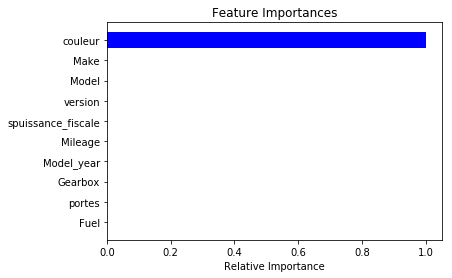

In [70]:
rfr.feature_importances_
features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [73]:
rfr.score(X_train.values, y_train.values)

0.9999999963370891

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = rfr.predict(X_test.values)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"mean absolute error: {mae:.2f}")
print(f"mean squared error: {mse:.2f}")
print(f"root mean squared error: {rmse:.2f}")

mean absolute error: 0.04
mean squared error: 0.05
root mean squared error: 0.22


In [34]:
y_train.values

array([4607,  459, 1345, ..., 4607, 2650, 3311])

In [76]:
y_pred

array([2650. , 4607. ,  915. , ...,  829. , 4607. , 2309.8])

In [78]:
y_test.values

array([2650, 4607,  915, ...,  829, 4607, 2310])

In [80]:
np.sum((y_test - y_pred)**2)/len(y_test)

0.04644069928310937